**Core Libaries**


In [ ]:
%pip -q install yfinance pandas numpy matplotlib scikit-learn \
               "stable-baselines3[extra]" gymnasium "shimmy>=2.0"

import os, math, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import yfinance as yf

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.utils import set_random_seed

import torch as th
from torch import nn

# Plot style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True, "axes.spines.top": False, "axes.spines.right": False,
    "axes.titlesize": 14, "axes.labelsize": 12, "legend.fontsize": 10,
})

# Reproducibility
seed = 42
np.random.seed(seed); random.seed(seed); th.manual_seed(seed); set_random_seed(seed)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 18.3 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Train on 2015–2019; test on 2020–2025
TRAIN_START, TRAIN_END = "2015-01-01", "2019-12-31"
TEST_START,  TEST_END  = "2020-01-01", "2025-01-01"

# Six asset classes (long-only)
EQUITIES   = ["SPY", "QQQ", "IWM", "EFA"]
BONDS      = ["TLT", "IEF", "LQD", "HYG"]
COMMODS    = ["GLD", "DBC"]
CRYPTO     = ["BTC-USD", "ETH-USD"]
CURRENCIES = ["UUP", "FXE"]
MACRO_TICKERS = ["^VIX", "^GSPC", "^NDX"]

ASSET_TICKERS = list(dict.fromkeys(EQUITIES + BONDS + COMMODS + CRYPTO + CURRENCIES))
ALL_TICKERS   = ASSET_TICKERS + MACRO_TICKERS

INITIAL_CAPITAL   = 1_000_000.0
STATE_WINDOW      = 30                   # days of feature history in state
REWARD_RET_WINDOW = 20                   # rolling window for risk metrics
TRADING_COST_BPS  = 12                   # discourage churn
REBAL_EVERY       = 5                    # trade weekly (~5 trading days)


In [ ]:
print("Downloading:", ALL_TICKERS)
raw = yf.download(ALL_TICKERS, start=TRAIN_START, end=TEST_END, auto_adjust=True, progress=False)
close = raw["Close"].dropna(how="all").ffill().dropna()

asset_prices = close[[t for t in ASSET_TICKERS if t in close.columns]].copy()
macro_prices = close[[t for t in MACRO_TICKERS if t in close.columns]].copy()

asset_logret = np.log(asset_prices / asset_prices.shift(1)).fillna(0.0)
display(asset_prices.tail(2))


Downloading: ['SPY', 'QQQ', 'IWM', 'EFA', 'TLT', 'IEF', 'LQD', 'HYG', 'GLD', 'DBC', 'BTC-USD', 'ETH-USD', 'UUP', 'FXE', '^VIX', '^GSPC', '^NDX']


Ticker,SPY,QQQ,IWM,EFA,TLT,IEF,LQD,HYG,GLD,DBC,BTC-USD,ETH-USD,UUP,FXE
Date,,,,,,,,,,,,,,
2024-12-30,583.110596,513.669128,218.957687,74.322861,84.386070,89.463745,102.789047,74.611618,240.630005,21.270000,92643.210938,3356.392578,29.290001,95.081764
2024-12-31,580.989136,509.305664,219.235504,74.322861,83.934326,89.299522,102.529938,74.602119,242.130005,21.379999,93429.203125,3332.531738,29.420000,94.705566


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
def rsi(prices: pd.Series, period=14):
    d = prices.diff(); up = d.clip(lower=0.0); down = -d.clip(upper=0.0)
    return 100 - 100/(1 + up.rolling(period).mean()/(down.rolling(period).mean()+1e-8))

def ema(x: pd.Series, span: int): return x.ewm(span=span, adjust=False).mean()

def bollinger_pct_b(px, window=20, n=2):
    ma = px.rolling(window).mean(); sd = px.rolling(window).std()
    upper, lower = ma + n*sd, ma - n*sd
    return (px - lower) / (upper - lower + 1e-8)

def stochastic_k(px, window=14):
    low, high = px.rolling(window).min(), px.rolling(window).max()
    return 100 * (px - low) / (high - low + 1e-8)

def stochastic_d(k, window=3): return k.rolling(window).mean()
def williams_r(px, window=14):
    low, high = px.rolling(window).min(), px.rolling(window).max()
    return -100 * (high - px) / (high - low + 1e-8)

feat = {}
rets_pct = asset_prices.pct_change()
spy_ret = asset_logret["SPY"] if "SPY" in asset_logret.columns else rets_pct.mean(axis=1)

for t in ASSET_TICKERS:
    px = asset_prices[t]; r = rets_pct[t]; lr = asset_logret[t]
    ma20 = px.rolling(20).mean()/(px+1e-8); ma60 = px.rolling(60).mean()/(px+1e-8)
    vol20 = r.rolling(20).std().fillna(0.0)
    rsi14 = (rsi(px,14)/100).fillna(0.5)
    macd  = (ema(px,12)-ema(px,26))/(px+1e-8); macds = ema(ema(px,12)-ema(px,26),9)/(px+1e-8)
    bb    = bollinger_pct_b(px).fillna(0.5)
    k     = stochastic_k(px).fillna(50.0)/100.0; d = stochastic_d(k*100).fillna(50.0)/100.0
    wr    = (williams_r(px)/-100.0).fillna(0.5)
    skew20 = r.rolling(20).skew().fillna(0.0); kurt20 = r.rolling(20).kurt().fillna(0.0)
    corr60 = r.rolling(60).corr(spy_ret).fillna(0.0)
    beta60 = (r.rolling(60).cov(spy_ret)/(spy_ret.rolling(60).var()+1e-8)).fillna(0.0)
    mom60  = (px/px.shift(60)-1).fillna(0.0); rank_cs = mom60.rank(axis=0, pct=True)

    vol_q1 = rets_pct.rolling(20).std().quantile(0.33, axis=1)
    vol_q2 = rets_pct.rolling(20).std().quantile(0.66, axis=1)
    low_b  = ((vol20 <= vol_q1).astype(float)).fillna(0.0)
    high_b = ((vol20 >= vol_q2).astype(float)).fillna(0.0)
    mid_b  = (1.0 - low_b - high_b).clip(0,1)

    feat[(t,"ret")] = lr; feat[(t,"ma20")] = ma20; feat[(t,"ma60")] = ma60; feat[(t,"vol20")] = vol20
    feat[(t,"rsi14")] = rsi14; feat[(t,"macd")] = macd; feat[(t,"macdsig")] = macds
    feat[(t,"bb%")] = bb; feat[(t,"%K")] = k; feat[(t,"%D")] = d; feat[(t,"wr")] = wr
    feat[(t,"skew20")] = skew20; feat[(t,"kurt20")] = kurt20
    feat[(t,"corr60SPY")] = corr60; feat[(t,"beta60SPY")] = beta60; feat[(t,"rankCS60")] = rank_cs
    feat[(t,"volLow")] = low_b; feat[(t,"volMid")] = mid_b; feat[(t,"volHigh")] = high_b

# Macro features
if "^VIX" in macro_prices.columns:
    vix = macro_prices["^VIX"]; feat[("MACRO","vix")] = vix
    feat[("MACRO","vix_ret")] = np.log(vix/vix.shift(1)).fillna(0.0)
if "^GSPC" in macro_prices.columns:
    spx = macro_prices["^GSPC"]; feat[("MACRO","spx")] = spx
    feat[("MACRO","spx_ret")] = np.log(spx/spx.shift(1)).fillna(0.0)
if "^NDX" in macro_prices.columns:
    ndx = macro_prices["^NDX"]; feat[("MACRO","ndx")] = ndx
    feat[("MACRO","ndx_ret")] = np.log(ndx/ndx.shift(1)).fillna(0.0)

features = pd.DataFrame(feat).dropna().astype(float)
asset_prices = asset_prices.loc[features.index]
asset_logret = asset_logret.loc[features.index]
print("features shape:", features.shape)


features shape: (2551, 272)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
train_mask = (features.index >= TRAIN_START) & (features.index <= TRAIN_END)
test_mask  = (features.index >= TEST_START)  & (features.index <= TEST_END)

train_features = features.loc[train_mask]
test_features  = features.loc[test_mask]
train_prices   = asset_prices.loc[train_mask]
test_prices    = asset_prices.loc[test_mask]
train_logret   = asset_logret.loc[train_mask]
test_logret    = asset_logret.loc[test_mask]

scaler = StandardScaler().fit(train_features.values)
train_feat_scaled = pd.DataFrame(scaler.transform(train_features.values), index=train_features.index, columns=train_features.columns)
test_feat_scaled  = pd.DataFrame(scaler.transform(test_features.values),  index=test_features.index,  columns=test_features.columns)

# Risk-parity prior (no cash weight yet)
vol_train   = train_prices.pct_change().dropna().std()
prior_risky = (1 / (vol_train + 1e-8)); prior_risky = (prior_risky / prior_risky.sum()).values
PRIOR_FULL  = np.concatenate([[0.0], prior_risky]); PRIOR_FULL = PRIOR_FULL / PRIOR_FULL.sum()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class MultiAssetPortfolioEnv(gym.Env):
    """
    Portfolio env (Gymnasium API):
      - State: last `window` rows of scaled features, current weights, value ratio
      - Action: continuous -> softmax weights for [CASH + risky assets]
      - Weekly rebalancing (rebalance_every)
      - Reward: log return + Sharpe/Sortino - drawdown/turnover - CVaR - concentration
                + entropy - KL(prior)  (risk-parity prior)
      - augment=True adds tiny return noise during training
    """
    metadata = {"render_modes": ["human"]}

    def __init__(self, prices_df, logret_df, feat_df, window=30,
                 trading_cost_bps=12, initial_value=1_000_000.0, ret_window=20,
                 rebalance_every=5, prior_w=None, augment=False):
        super().__init__()
        self.prices, self.logret, self.features = prices_df, logret_df, feat_df
        self.dates = prices_df.index
        self.assets = list(prices_df.columns)
        self.n_risky = len(self.assets)
        self.n_assets = self.n_risky + 1  # + cash

        self.window = int(window)
        self.trading_cost = trading_cost_bps / 10_000
        self.initial_value = float(initial_value)
        self.ret_window = int(ret_window)
        self.rebalance_every = int(rebalance_every)
        self.augment = bool(augment)

        # prior
        if prior_w is None or len(prior_w) != self.n_assets:
            self.prior_w = np.ones(self.n_assets, dtype=np.float32) / self.n_assets
        else:
            p = np.asarray(prior_w, dtype=np.float32); self.prior_w = p / p.sum()

        self.feature_dim = self.features.shape[1]
        obs_dim = self.window * self.feature_dim + self.n_assets + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space      = spaces.Box(low=-10.0, high=10.0, shape=(self.n_assets,), dtype=np.float32)

        self._max_step = len(self.prices) - 1
        self._reset_state()

    # --- Gymnasium API ---
    def _obs(self):
        s, e = self.current_step - self.window, self.current_step
        win = self.features.iloc[s:e].values
        return np.concatenate([
            win.flatten().astype(np.float32),
            self.weights.astype(np.float32),
            np.array([self.portfolio_value / self.initial_value], dtype=np.float32)
        ])

    def _reset_state(self):
        self.current_step = self.window
        self.portfolio_value = self.initial_value
        self.weights = np.zeros(self.n_assets, dtype=np.float32); self.weights[0] = 1.0
        self.prev_weights = self.weights.copy()
        self.daily_log = []; self.peak_value = self.initial_value

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self._reset_state()
        return self._obs(), {}

    def step(self, action):
        prev_val = self.portfolio_value

        # Rebalance weekly
        do_rebalance = (self.current_step % self.rebalance_every == 0)
        if do_rebalance:
            a = np.clip(np.asarray(action, dtype=np.float32).flatten(), -10, 10)
            exps = np.exp(a - a.max()); new_w = exps / exps.sum()
        else:
            new_w = self.weights.copy()

        # Transaction costs
        turnover = float(np.abs(new_w - self.weights).sum())
        self.portfolio_value -= self.trading_cost * turnover * self.portfolio_value

        # Apply returns (cash=0)
        risky = self.logret.iloc[self.current_step].values
        asset_lr = np.concatenate([[0.0], risky])
        if self.augment:
            asset_lr = asset_lr + np.random.normal(0, 0.0005, size=asset_lr.shape)  # ~5 bps std
        gross = float(np.exp(np.dot(new_w, asset_lr)))
        self.portfolio_value *= gross

        # Base log-return
        log_ret = float(np.log(self.portfolio_value / prev_val + 1e-12))
        self.daily_log.append(log_ret)

        # Rolling risk stats
        if len(self.daily_log) >= self.ret_window:
            recent = np.array(self.daily_log[-self.ret_window:])
            mu = float(recent.mean()); sd = float(recent.std() + 1e-6)
            sharpe = mu / sd
            downside = recent[recent < 0]
            sortino = mu / float(downside.std() + 1e-6) if len(downside) else 0.0
            var5 = float(np.percentile(recent, 5))
            cvar_pen = -float(recent[recent <= var5].mean()) if np.any(recent <= var5) else 0.0
        else:
            sharpe = sortino = cvar_pen = 0.0

        # Drawdown
        self.peak_value = max(self.peak_value, self.portfolio_value)
        drawdown = max(0.0, (self.peak_value - self.portfolio_value) / (self.peak_value + 1e-6))

        # Diversity / concentration / stability
        entropy = -float(np.sum(new_w * np.log(new_w + 1e-8)))
        hhi_excess = max(0.0, float(np.sum(new_w**2)) - 1.0/self.n_assets)
        change_l1 = float(np.abs(new_w - self.weights).sum())
        change_l2 = float(np.sum((new_w - self.weights)**2))
        # Regime amp via VIX (scaled value in features)
        try:
            vix_scaled = float(self.features.iloc[self.current_step][('MACRO','vix')])
            risk_amp = 1.0 + 0.25 * max(0.0, vix_scaled)
        except Exception:
            risk_amp = 1.0
        # KL to prior (risk-parity)
        kl_prior = float(np.sum(new_w * (np.log(new_w + 1e-8) - np.log(self.prior_w + 1e-8))))

        reward = (
            1.0 * log_ret +
            0.30 * sharpe + 0.20 * sortino -
            (0.05 * risk_amp) * drawdown -
            0.08 * change_l1 - 0.03 * change_l2 +
            0.04 * entropy -
            0.03 * hhi_excess -
            0.06 * cvar_pen -
            0.02 * kl_prior
        )
        reward = float(np.clip(reward, -5.0, 5.0))

        self.prev_weights = self.weights.copy(); self.weights = new_w
        self.current_step += 1
        terminated = self.current_step >= self._max_step
        truncated  = False
        info = {"portfolio_value": float(self.portfolio_value),
                "weights": self.weights.copy(),
                "date": self.dates[self.current_step - 1]}
        return self._obs(), reward, terminated, truncated, info


In [ ]:
# PPO knobs
N_ENVS        = 8            # use 1 or 2 if RAM is tight
TOTAL_STEPS   = 600_000      # use 60_000 for a quick smoke test
N_STEPS       = 4096
BATCH_SIZE    = 2048
N_EPOCHS      = 20
GAMMA         = 0.99
GAE_LAMBDA    = 0.95
CLIP_INIT     = 0.20
LR_INIT       = 3e-4
ENT_COEF      = 0.005
VF_COEF       = 0.5
MAX_GRAD_NORM = 0.5
TARGET_KL     = 0.015

def linear_schedule(initial_value):
    def f(progress_remaining: float):
        return progress_remaining * initial_value
    return f

def make_train_env(rank):
    def _thunk():
        return MultiAssetPortfolioEnv(
            prices_df=train_prices, logret_df=train_logret, feat_df=train_feat_scaled,
            window=STATE_WINDOW, trading_cost_bps=TRADING_COST_BPS, initial_value=INITIAL_CAPITAL,
            ret_window=REWARD_RET_WINDOW, rebalance_every=REBAL_EVERY, prior_w=PRIOR_FULL,
            augment=True
        )
    return _thunk

try:
    vec_train_env = SubprocVecEnv([make_train_env(i) for i in range(N_ENVS)])
except Exception:
    vec_train_env = DummyVecEnv([make_train_env(0)])

test_env = MultiAssetPortfolioEnv(
    prices_df=test_prices, logret_df=test_logret, feat_df=test_feat_scaled,
    window=STATE_WINDOW, trading_cost_bps=TRADING_COST_BPS, initial_value=INITIAL_CAPITAL,
    ret_window=REWARD_RET_WINDOW, rebalance_every=REBAL_EVERY, prior_w=PRIOR_FULL,
    augment=False
)

policy_kwargs = dict(
    activation_fn=nn.SiLU,
    net_arch=[dict(pi=[512, 256, 128], vf=[512, 256, 128])],
    ortho_init=False,
)

ppo = PPO(
    "MlpPolicy", vec_train_env,
    n_steps=N_STEPS, batch_size=BATCH_SIZE, n_epochs=N_EPOCHS,
    gamma=GAMMA, gae_lambda=GAE_LAMBDA,
    clip_range=linear_schedule(CLIP_INIT),
    learning_rate=linear_schedule(LR_INIT),
    ent_coef=ENT_COEF, vf_coef=VF_COEF, max_grad_norm=MAX_GRAD_NORM,
    target_kl=TARGET_KL, normalize_advantage=True,
    policy_kwargs=policy_kwargs, verbose=1, seed=seed
)


Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow(

In [ ]:
from copy import deepcopy
import tempfile

# 2019 validation slice
val_mask = (train_prices.index >= "2019-01-01") & (train_prices.index <= "2019-12-31")
val_env = MultiAssetPortfolioEnv(
    prices_df=train_prices.loc[val_mask], logret_df=train_logret.loc[val_mask],
    feat_df=train_feat_scaled.loc[val_mask], window=STATE_WINDOW,
    trading_cost_bps=TRADING_COST_BPS, initial_value=INITIAL_CAPITAL,
    ret_window=REWARD_RET_WINDOW, rebalance_every=REBAL_EVERY, prior_w=PRIOR_FULL,
    augment=False
)

def run_policy_gym(env, model):
    obs, _ = env.reset(); terminated = truncated = False
    vals, dates, ws = [], [], []
    while not (terminated or truncated):
        act, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(act)
        vals.append(info["portfolio_value"]); dates.append(info["date"]); ws.append(info["weights"])
    return pd.Series(vals, index=pd.to_datetime(dates)), np.vstack(ws)

best_sr = -1e9
best_model_path = None

# Create a temporary directory to save models
with tempfile.TemporaryDirectory() as tmpdir:
    CHUNKS = max(1, TOTAL_STEPS // 100_000)
    for i in range(CHUNKS):
        ppo.learn(total_timesteps=100_000, progress_bar=False)
        val_curve, _ = run_policy_gym(val_env, ppo)
        r = val_curve.pct_change().dropna()
        sr = (r.mean() / (r.std() + 1e-12)) * np.sqrt(252)
        if sr > best_sr:
            best_sr = sr
            current_model_path = os.path.join(tmpdir, f"best_ppo_model_{i}.zip")
            ppo.save(current_model_path)
            best_model_path = current_model_path

    if best_model_path:
        ppo = PPO.load(best_model_path)
    else:
        print("Warning: No best model found or saved.")


------------------------------
| time/              |       |
|    fps             | 2353  |
|    iterations      | 1     |
|    time_elapsed    | 13    |
|    total_timesteps | 32768 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1560         |
|    iterations           | 2            |
|    time_elapsed         | 42           |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 7.767812e-08 |
|    clip_fraction        | 0            |
|    clip_range           | 0.134        |
|    entropy_loss         | -21.3        |
|    explained_variance   | 0.229        |
|    learning_rate        | 0.000202     |
|    loss                 | 66.5         |
|    n_updates            | 99           |
|    policy_gradient_loss | -1.87e-05    |
|    std                  | 1            |
|    value_loss           | 3.92e+05     |
---------

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| time/                   |               |
|    fps                  | 1545          |
|    iterations           | 2             |
|    time_elapsed         | 42            |
|    total_timesteps      | 65536         |
| train/                  |               |
|    approx_kl            | 1.3109457e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.134         |
|    entropy_loss         | -21.3         |
|    explained_variance   | 0.582         |
|    learning_rate        | 0.000202      |
|    loss                 | 766           |
|    n_updates            | 179           |
|    policy_gradient_loss | -4.52e-06     |
|    std                  | 1             |
|    value_loss           | 3.56e+06      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1391          |
|    iterations           | 3   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| time/                   |               |
|    fps                  | 1552          |
|    iterations           | 2             |
|    time_elapsed         | 42            |
|    total_timesteps      | 65536         |
| train/                  |               |
|    approx_kl            | 3.2105163e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.134         |
|    entropy_loss         | -21.3         |
|    explained_variance   | 0.724         |
|    learning_rate        | 0.000202      |
|    loss                 | 2.25e+03      |
|    n_updates            | 259           |
|    policy_gradient_loss | -6.91e-07     |
|    std                  | 1             |
|    value_loss           | 1.38e+07      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1393          |
|    iterations           | 3   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| time/                   |               |
|    fps                  | 1561          |
|    iterations           | 2             |
|    time_elapsed         | 41            |
|    total_timesteps      | 65536         |
| train/                  |               |
|    approx_kl            | 5.0786184e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.134         |
|    entropy_loss         | -21.3         |
|    explained_variance   | 0.769         |
|    learning_rate        | 0.000202      |
|    loss                 | 2.88e+03      |
|    n_updates            | 339           |
|    policy_gradient_loss | -5.86e-07     |
|    std                  | 1             |
|    value_loss           | 4.75e+07      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1402          |
|    iterations           | 3   

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 1544         |
|    iterations           | 2            |
|    time_elapsed         | 42           |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 1.366061e-09 |
|    clip_fraction        | 0            |
|    clip_range           | 0.134        |
|    entropy_loss         | -21.3        |
|    explained_variance   | 0.813        |
|    learning_rate        | 0.000202     |
|    loss                 | 2.17e+04     |
|    n_updates            | 419          |
|    policy_gradient_loss | -3.17e-07    |
|    std                  | 1            |
|    value_loss           | 1.18e+08     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1377          |
|    iterations           | 3             |
|    ti

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| time/                   |               |
|    fps                  | 1543          |
|    iterations           | 2             |
|    time_elapsed         | 42            |
|    total_timesteps      | 65536         |
| train/                  |               |
|    approx_kl            | -7.237759e-09 |
|    clip_fraction        | 0             |
|    clip_range           | 0.134         |
|    entropy_loss         | -21.3         |
|    explained_variance   | 0.845         |
|    learning_rate        | 0.000202      |
|    loss                 | 2.49e+03      |
|    n_updates            | 499           |
|    policy_gradient_loss | -8.12e-08     |
|    std                  | 1             |
|    value_loss           | 2.44e+08      |
-------------------------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 1388           |
|    iterations           | 3

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
ppo_values, ppo_weights = run_policy_gym(test_env, ppo)
display(ppo_values.head())
print("PPO weights:", ppo_weights.shape)


,0
2020-01-31,990997.534667
2020-02-01,992683.624707
2020-02-02,994267.708795
2020-02-03,994871.271340
2020-02-04,996368.635830


PPO weights: (1796, 15)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
from scipy.optimize import minimize

def bh_series(prices: pd.Series, initial=INITIAL_CAPITAL):
    return initial * (prices / prices.iloc[0])

def equal_weight_bh(prices_df: pd.DataFrame, initial=INITIAL_CAPITAL):
    rel = prices_df / prices_df.iloc[0]; return initial * rel.mean(axis=1)

def portfolio_value_from_weights(prices_df: pd.DataFrame, w: np.ndarray, initial=INITIAL_CAPITAL):
    rel = prices_df / prices_df.iloc[0]; return initial * (rel @ w)

def mvo_max_sharpe(prices_df_train: pd.DataFrame, prices_df_test: pd.DataFrame, rf=0.0):
    rets = prices_df_train.pct_change().dropna()
    mu, cov = rets.mean().values, rets.cov().values; n = len(mu)
    bounds = [(0,1)]*n; cons = ({'type':'eq','fun':lambda w: np.sum(w)-1})
    def neg_sharpe(w):
        r = (w@mu)*252; v = math.sqrt(w@cov@w)*math.sqrt(252); return -(r-rf)/(v+1e-12)
    w0 = np.ones(n)/n; res = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)
    w = res.x if res.success else w0
    return portfolio_value_from_weights(prices_df_test, w)

def risk_parity_invvol(prices_df_train: pd.DataFrame, prices_df_test: pd.DataFrame):
    vol = prices_df_train.pct_change().dropna().std()
    w = (1/(vol+1e-8)); w = (w/w.sum()).values
    return portfolio_value_from_weights(prices_df_test, w)

test_prices_aligned = test_prices.loc[ppo_values.index]

curves = {"PPO": ppo_values}
if "SPY" in test_prices_aligned.columns:
    curves["Buy & Hold SPY"] = bh_series(test_prices_aligned["SPY"])
curves["Equal-Weight BH"]   = equal_weight_bh(test_prices_aligned)
curves["MVO (Max Sharpe)"]  = mvo_max_sharpe(train_prices, test_prices_aligned)
curves["Risk Parity (InvVol)"] = risk_parity_invvol(train_prices, test_prices_aligned)

def metrics(series: pd.Series, freq=252, rf=0.0):
    rets = series.pct_change().dropna()
    cum = series.iloc[-1]/series.iloc[0] - 1
    ann = (1+cum)**(freq/len(rets)) - 1
    vol = rets.std()*math.sqrt(freq)
    down = rets[rets<0]; sortino = (ann-rf)/(down.std()*math.sqrt(freq)+1e-12) if len(down) else np.nan
    sharpe  = (ann-rf)/(vol+1e-12) if vol>0 else np.nan
    dd = ((series - series.cummax())/series.cummax()).min()
    return {"Cumulative Return": cum, "Annualized Return": ann, "Annualized Volatility": vol,
            "Sharpe Ratio": sharpe, "Sortino Ratio": sortino, "Max Drawdown": dd}

metrics_df = pd.DataFrame({k: metrics(v) for k,v in curves.items()}).T
display(metrics_df.style.format({
    "Cumulative Return":"{:.2%}", "Annualized Return":"{:.2%}",
    "Annualized Volatility":"{:.2%}", "Sharpe Ratio":"{:.2f}",
    "Sortino Ratio":"{:.2f}", "Max Drawdown":"{:.2%}",
}))


,Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
PPO,65.53%,7.33%,12.00%,0.61,0.72,-29.31%
Buy & Hold SPY,97.20%,10.00%,17.53%,0.57,0.58,-33.72%
Equal-Weight BH,220.33%,17.76%,31.67%,0.56,0.73,-58.16%
MVO (Max Sharpe),15.41%,2.03%,1.66%,1.22,1.38,-2.39%
Risk Parity (InvVol),40.16%,4.85%,9.18%,0.53,0.66,-25.44%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


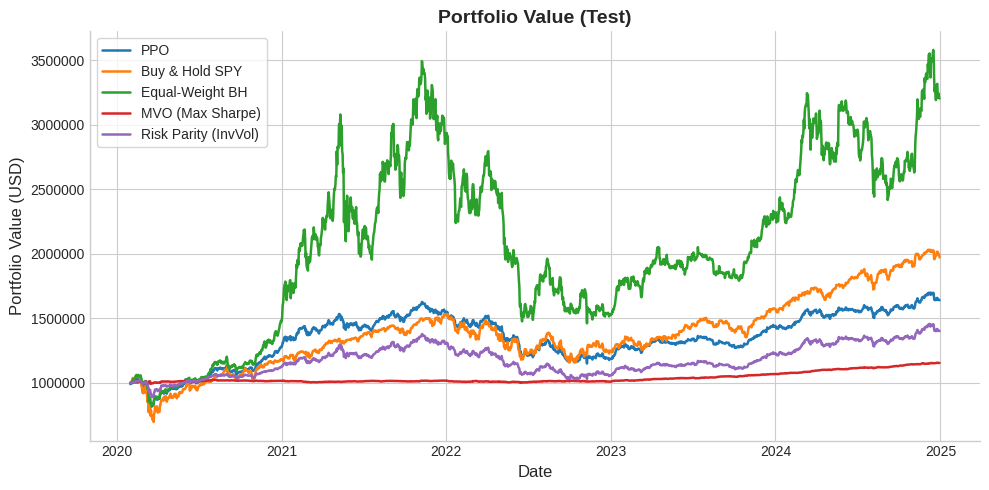

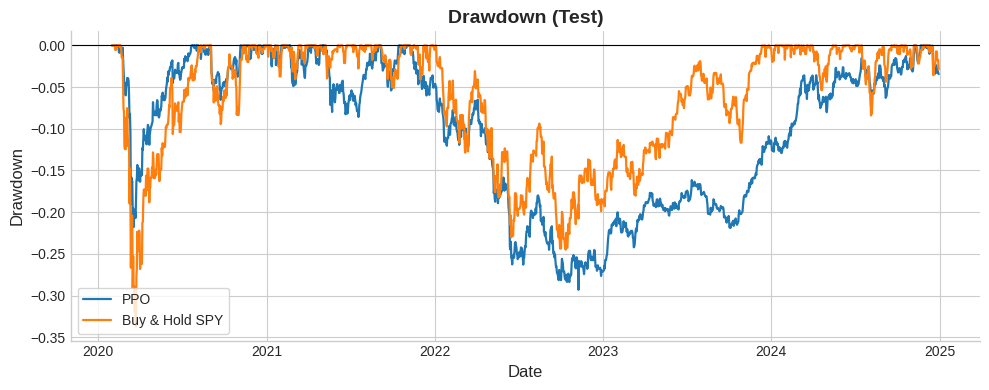

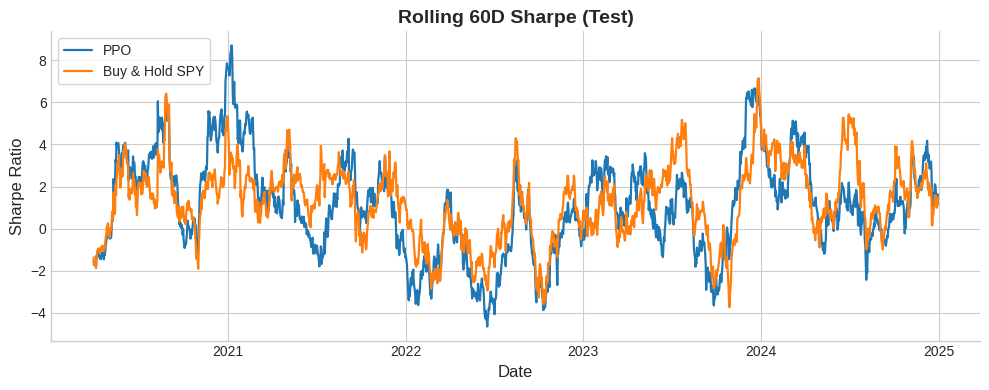

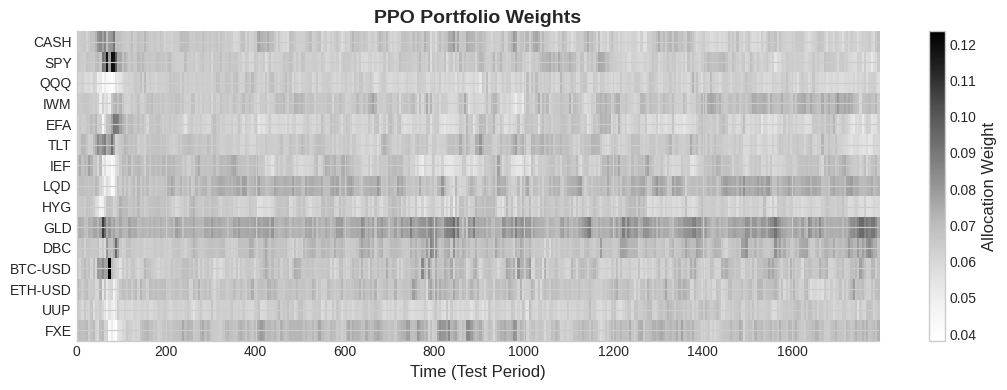

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
def plot_equity(curves: dict, title="Portfolio Value (Test)"):
    fig, ax = plt.subplots(figsize=(10,5))
    for name, s in curves.items(): ax.plot(s.index, s.values, label=name, linewidth=1.8)
    ax.set_title(title, weight="bold"); ax.set_xlabel("Date"); ax.set_ylabel("Portfolio Value (USD)")
    ax.ticklabel_format(axis="y", style="plain"); ax.legend(loc="upper left", frameon=True)
    fig.tight_layout(); plt.show()

def drawdown(s: pd.Series): return (s - s.cummax())/s.cummax()

def plot_drawdown(curves: dict, title="Drawdown (Test)"):
    fig, ax = plt.subplots(figsize=(10,4))
    for name, s in curves.items(): ax.plot(s.index, drawdown(s).values, label=name, linewidth=1.6)
    ax.set_title(title, weight="bold"); ax.set_xlabel("Date"); ax.set_ylabel("Drawdown")
    ax.axhline(0, color="black", linewidth=0.8); ax.legend(loc="lower left", frameon=True)
    fig.tight_layout(); plt.show()

def rolling_sharpe(s: pd.Series, window=60, freq=252):
    r = s.pct_change(); return (r.rolling(window).mean()/(r.rolling(window).std()+1e-12))*math.sqrt(freq)

def plot_rolling_sharpe(curves: dict, title="Rolling 60D Sharpe (Test)"):
    fig, ax = plt.subplots(figsize=(10,4))
    for name, s in curves.items(): ax.plot(rolling_sharpe(s).index, rolling_sharpe(s).values, label=name, linewidth=1.6)
    ax.set_title(title, weight="bold"); ax.set_xlabel("Date"); ax.set_ylabel("Sharpe Ratio")
    ax.legend(loc="upper left", frameon=True); fig.tight_layout(); plt.show()

plot_equity(curves)
plot_drawdown({"PPO": curves["PPO"], "Buy & Hold SPY": curves.get("Buy & Hold SPY", curves["PPO"])})
plot_rolling_sharpe({"PPO": curves["PPO"], "Buy & Hold SPY": curves.get("Buy & Hold SPY", curves["PPO"])})

# Optional: PPO weights heatmap
try:
    labels = ["CASH"] + list(test_prices_aligned.columns)
    fig, ax = plt.subplots(figsize=(11,4))
    im = ax.imshow(ppo_weights.T, aspect="auto", interpolation="nearest")
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    ax.set_xlabel("Time (Test Period)"); ax.set_title("PPO Portfolio Weights", weight="bold")
    cbar = fig.colorbar(im, ax=ax); cbar.set_label("Allocation Weight")
    fig.tight_layout(); plt.show()
except Exception:
    pass


In [ ]:
# === Metrics Table: PPO vs Baselines (slide-ready) ===
import math, numpy as np, pandas as pd
from scipy.optimize import minimize

INITIAL_CAPITAL = 1_000_000.0

def bh_series(prices: pd.Series, initial=INITIAL_CAPITAL):
    return initial * (prices / prices.iloc[0])

def equal_weight_bh(prices_df: pd.DataFrame, initial=INITIAL_CAPITAL):
    rel = prices_df / prices_df.iloc[0]
    return initial * rel.mean(axis=1)

def portfolio_value_from_weights(prices_df: pd.DataFrame, w: np.ndarray, initial=INITIAL_CAPITAL):
    rel = prices_df / prices_df.iloc[0]
    return initial * (rel @ w)

def mvo_max_sharpe(prices_df_train: pd.DataFrame, prices_df_test: pd.DataFrame, rf=0.0):
    rets = prices_df_train.pct_change().dropna()
    mu, cov = rets.mean().values, rets.cov().values
    n = len(mu)
    bounds = [(0.0, 1.0)] * n
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0})
    def neg_sharpe(w):
        r = (w @ mu) * 252
        v = math.sqrt(w @ cov @ w) * math.sqrt(252)
        return -(r - rf) / (v + 1e-12)
    w0 = np.ones(n) / n
    res = minimize(neg_sharpe, w0, bounds=bounds, constraints=cons)
    w = res.x if res.success else w0
    return portfolio_value_from_weights(prices_df_test, w)

def risk_parity_invvol(prices_df_train: pd.DataFrame, prices_df_test: pd.DataFrame):
    vol = prices_df_train.pct_change().dropna().std()
    w = (1 / (vol + 1e-8)); w = (w / w.sum()).values
    return portfolio_value_from_weights(prices_df_test, w)

def metrics(series: pd.Series, freq=252, rf=0.0):
    rets = series.pct_change().dropna()
    cum = series.iloc[-1] / series.iloc[0] - 1
    ann = (1 + cum) ** (freq / len(rets)) - 1
    vol = rets.std() * math.sqrt(freq)
    down = rets[rets < 0]
    sortino = (ann - rf) / (down.std() * math.sqrt(freq) + 1e-12) if len(down) else np.nan
    sharpe  = (ann - rf) / (vol + 1e-12) if vol > 0 else np.nan
    dd = ((series - series.cummax()) / series.cummax()).min()
    return {
        "Cumulative Return": cum,
        "Annualized Return": ann,
        "Annualized Volatility": vol,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Max Drawdown": dd,
    }

# Align test prices to PPO dates
test_prices_aligned = test_prices.loc[ppo_values.index]

# Build curves
curves = {"PPO": ppo_values}
if "SPY" in test_prices_aligned.columns:
    curves["Buy & Hold SPY"] = bh_series(test_prices_aligned["SPY"])
curves["Equal-Weight BH"]   = equal_weight_bh(test_prices_aligned)
curves["MVO (Max Sharpe)"]  = mvo_max_sharpe(train_prices, test_prices_aligned)
curves["Risk Parity (InvVol)"] = risk_parity_invvol(train_prices, test_prices_aligned)

# Metrics table
metrics_df = pd.DataFrame({name: metrics(s) for name, s in curves.items()}).T
display(
    metrics_df.style
    .set_caption("Performance Summary (Test Period)")
    .format({
        "Cumulative Return": "{:.2%}",
        "Annualized Return": "{:.2%}",
        "Annualized Volatility": "{:.2%}",
        "Sharpe Ratio": "{:.2f}",
        "Sortino Ratio": "{:.2f}",
        "Max Drawdown": "{:.2%}",
    })
    .set_table_styles([
        {"selector": "th", "props": [("font-size", "12pt"), ("text-align", "center")]},
        {"selector": "td", "props": [("font-size", "11pt"), ("text-align", "center")]}
    ])
)


,Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
PPO,65.53%,7.33%,12.00%,0.61,0.72,-29.31%
Buy & Hold SPY,97.20%,10.00%,17.53%,0.57,0.58,-33.72%
Equal-Weight BH,220.33%,17.76%,31.67%,0.56,0.73,-58.16%
MVO (Max Sharpe),15.41%,2.03%,1.66%,1.22,1.38,-2.39%
Risk Parity (InvVol),40.16%,4.85%,9.18%,0.53,0.66,-25.44%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# === SAVE PPO TRAJECTORY FOR GAME (same format as TRPO) ===

import json

# 1. Dates
ppo_dates = ppo_values.index.strftime("%Y-%m-%d").tolist()

# 2. Portfolio values (list of floats)
ppo_values_list = ppo_values.tolist()

# 3. Weights already collected earlier as ppo_weights (NumPy array)
ppo_weights_list = ppo_weights.tolist()

# 4. Convert test set log-returns → simple returns for game
asset_daily_simple_returns = np.exp(test_logret.values) - 1.0
asset_returns_list = asset_daily_simple_returns.tolist()

# 5. Build JSON object using SAME KEY NAMES the game expects
ppo_data = {
    "dates": ppo_dates,
    "trpoPortfolio": ppo_values_list,   # keep this key for compatibility
    "trpoWeights": ppo_weights_list,    # keep this key for compatibility
    "assetReturns": asset_returns_list,
    "tickers": ASSET_TICKERS           # your asset ticker list from Python
}

from google.colab import files
files.download("ppo_trajectory.json")

<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<IPython.core.display.Javascript object>

In [ ]:
# Overall (cumulative) return for PPO over its available timeframe
import numpy as np

start_val = float(ppo_values.iloc[0])
end_val   = float(ppo_values.iloc[-1])

cum_return = end_val / start_val - 1.0

start_date = ppo_values.index[0].date()
end_date   = ppo_values.index[-1].date()
n_days     = len(ppo_values)

print(f"PPO period: {start_date} → {end_date}  ({n_days} points)")
print(f"PPO cumulative return: {cum_return:.2%}")


PPO period: 2020-01-31 → 2024-12-30  (1796 points)
PPO cumulative return: 65.53%


In [ ]:
ppo_rets = ppo_values.pct_change().dropna()
ann_return = (1 + ppo_rets.mean())**252 - 1   # 252 trading days
print(f"PPO annualized return: {ann_return:.2%}")


PPO annualized return: 8.11%


In [ ]:
# If you only have ppo_rets = daily % returns as a Series
cum_return_from_rets = (1 + ppo_rets).prod() - 1
print(f"PPO cumulative return (from returns): {cum_return_from_rets:.2%}")


PPO cumulative return (from returns): 65.53%


In [5]:
# --- Save month-aligned PPO trajectory for the game (run after you have ppo_values, ppo_weights, test_prices) ---
import json
import numpy as np
import pandas as pd
from calendar import monthrange
import yfinance as yf # Added for potential data download
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.utils import set_random_seed
import torch as th
from torch import nn
from sklearn.preprocessing import StandardScaler
import math
import random
import os # Added for tempfile if needed for model loading

# --- Conditionally define constants and core objects ---

if 'TRAIN_START' not in locals():
    TRAIN_START, TRAIN_END = "2015-01-01", "2019-12-31"
    TEST_START,  TEST_END  = "2020-01-01", "2025-01-01"

if 'STATE_WINDOW' not in locals():
    STATE_WINDOW      = 30
    REWARD_RET_WINDOW = 20
    TRADING_COST_BPS  = 12
    REBAL_EVERY       = 5
    INITIAL_CAPITAL   = 1_000_000.0
    seed = 42
    np.random.seed(seed); random.seed(seed); th.manual_seed(seed); set_random_seed(seed)

if 'ASSET_TICKERS' not in locals():
    EQUITIES   = ["SPY", "QQQ", "IWM", "EFA"]
    BONDS      = ["TLT", "IEF", "LQD", "HYG"]
    COMMODS    = ["GLD", "DBC"]
    CRYPTO     = ["BTC-USD", "ETH-USD"]
    CURRENCIES = ["UUP", "FXE"]
    MACRO_TICKERS = ["^VIX", "^GSPC", "^NDX"]
    ASSET_TICKERS = list(dict.fromkeys(EQUITIES + BONDS + COMMODS + CRYPTO + CURRENCIES))
    ALL_TICKERS   = ASSET_TICKERS + MACRO_TICKERS # Needed for yf.download

# --- Conditionally define feature functions ---
if 'rsi' not in locals():
    def rsi(prices: pd.Series, period=14):
        d = prices.diff(); up = d.clip(lower=0.0); down = -d.clip(upper=0.0)
        return 100 - 100/(1 + up.rolling(period).mean()/(down.rolling(period).mean()+1e-8))

    def ema(x: pd.Series, span: int): return x.ewm(span=span, adjust=False).mean()

    def bollinger_pct_b(px, window=20, n=2):
        ma = px.rolling(window).mean(); sd = px.rolling(window).std()
        upper, lower = ma + n*sd, ma - n*sd
        return (px - lower) / (upper - lower + 1e-8)

    def stochastic_k(px, window=14):
        low, high = px.rolling(window).min(), px.rolling(window).max()
        return 100 * (px - low) / (high - low + 1e-8)

    def stochastic_d(k, window=3): return k.rolling(window).mean()
    def williams_r(px, window=14):
        low, high = px.rolling(window).min(), px.rolling(window).max()
        return -100 * (high - px) / (high - low + 1e-8)


# --- Conditionally re-download data and set up dataframes ---
if 'asset_prices' not in locals() or 'test_prices' not in locals() or 'features' not in locals():
    print("Re-downloading data and setting up asset_prices/test_prices/features...")
    raw = yf.download(ALL_TICKERS, start=TRAIN_START, end=TEST_END, auto_adjust=True, progress=False)
    close = raw["Close"].dropna(how="all").ffill().dropna()
    asset_prices = close[[t for t in ASSET_TICKERS if t in close.columns]].copy()
    macro_prices = close[[t for t in MACRO_TICKERS if t in close.columns]].copy()
    asset_logret = np.log(asset_prices / asset_prices.shift(1)).fillna(0.0)

    feat = {}
    rets_pct = asset_prices.pct_change()
    spy_ret = asset_logret["SPY"] if "SPY" in asset_logret.columns else rets_pct.mean(axis=1)

    for t in ASSET_TICKERS:
        px = asset_prices[t]; r = rets_pct[t]; lr = asset_logret[t]
        ma20 = px.rolling(20).mean()/(px+1e-8); ma60 = px.rolling(60).mean()/(px+1e-8)
        vol20 = r.rolling(20).std().fillna(0.0)
        rsi14 = (rsi(px,14)/100).fillna(0.5)
        macd  = (ema(px,12)-ema(px,26))/(px+1e-8); macds = ema(ema(px,12)-ema(px,26),9)/(px+1e-8)
        bb    = bollinger_pct_b(px).fillna(0.5)
        k     = stochastic_k(px).fillna(50.0)/100.0; d = stochastic_d(k*100).fillna(50.0)/100.0
        wr    = (williams_r(px)/-100.0).fillna(0.5)
        skew20 = r.rolling(20).skew().fillna(0.0); kurt20 = r.rolling(20).kurt().fillna(0.0)
        corr60 = r.rolling(60).corr(spy_ret).fillna(0.0)
        beta60 = (r.rolling(60).cov(spy_ret)/(spy_ret.rolling(60).var()+1e-8)).fillna(0.0)
        mom60  = (px/px.shift(60)-1).fillna(0.0); rank_cs = mom60.rank(axis=0, pct=True)

        vol_q1 = rets_pct.rolling(20).std().quantile(0.33, axis=1)
        vol_q2 = rets_pct.rolling(20).std().quantile(0.66, axis=1)
        low_b  = ((vol20 <= vol_q1).astype(float)).fillna(0.0)
        high_b = ((vol20 >= vol_q2).astype(float)).fillna(0.0)
        mid_b  = (1.0 - low_b - high_b).clip(0,1)

        feat[(t,"ret")] = lr; feat[(t,"ma20")] = ma20; feat[(t,"ma60")] = ma60; feat[(t,"vol20")] = vol20
        feat[(t,"rsi14")] = rsi14; feat[(t,"macd")] = macd; feat[(t,"macdsig")] = macds
        feat[(t,"bb%")] = bb; feat[(t,"K%")] = k; feat[(t,"D%")] = d; feat[(t,"wr")] = wr
        feat[(t,"skew20")] = skew20; feat[(t,"kurt20")] = kurt20
        feat[(t,"corr60SPY")] = corr60; feat[(t,"beta60SPY")] = beta60; feat[(t,"rankCS60")] = rank_cs
        feat[(t,"volLow")] = low_b; feat[(t,"volMid")] = mid_b; feat[(t,"volHigh")] = high_b

    # Macro features
    if "^VIX" in macro_prices.columns:
        vix = macro_prices["^VIX"]; feat[("MACRO","vix")] = vix
        feat[("MACRO","vix_ret")] = np.log(vix/vix.shift(1)).fillna(0.0)
    if "^GSPC" in macro_prices.columns:
        spx = macro_prices["^GSPC"]; feat[("MACRO","spx")] = spx
        feat[("MACRO","spx_ret")] = np.log(spx/spx.shift(1)).fillna(0.0)
    if "^NDX" in macro_prices.columns:
        ndx = macro_prices["^NDX"]; feat[("MACRO","ndx")] = ndx
        feat[("MACRO","ndx_ret")] = np.log(ndx/ndx.shift(1)).fillna(0.0)

    features = pd.DataFrame(feat).dropna().astype(float)
    asset_prices = asset_prices.loc[features.index]
    asset_logret = asset_logret.loc[features.index]

    train_mask = (features.index >= TRAIN_START) & (features.index <= TRAIN_END)
    test_mask  = (features.index >= TEST_START)  & (features.index <= TEST_END)

    train_features = features.loc[train_mask]
    test_features  = features.loc[test_mask]
    train_prices   = asset_prices.loc[train_mask]
    test_prices    = asset_prices.loc[test_mask]
    train_logret   = asset_logret.loc[train_mask]
    test_logret    = asset_logret.loc[test_mask]

    scaler = StandardScaler().fit(train_features.values)
    train_feat_scaled = pd.DataFrame(scaler.transform(train_features.values), index=train_features.index, columns=train_features.columns)
    test_feat_scaled  = pd.DataFrame(scaler.transform(test_features.values),  index=test_features.index,  columns=test_features.columns)

    vol_train   = train_prices.pct_change().dropna().std()
    prior_risky = (1 / (vol_train + 1e-8)); prior_risky = (prior_risky / prior_risky.sum()).values
    PRIOR_FULL  = np.concatenate([[0.0], prior_risky]); PRIOR_FULL = PRIOR_FULL / PRIOR_FULL.sum()

# --- Conditionally define MultiAssetPortfolioEnv class ---
if 'MultiAssetPortfolioEnv' not in locals():
    class MultiAssetPortfolioEnv(gym.Env):
        """
        Portfolio env (Gymnasium API):
          - State: last `window` rows of scaled features, current weights, value ratio
          - Action: continuous -> softmax weights for [CASH + risky assets]
          - Weekly rebalancing (rebalance_every)
          - Reward: log return + Sharpe/Sortino - drawdown/turnover - CVaR - concentration
                        + entropy - KL(prior)  (risk-parity prior)
          - augment=True adds tiny return noise during training
        """
        metadata = {"render_modes": ["human"]}

        def __init__(self, prices_df, logret_df, feat_df, window=30,
                     trading_cost_bps=12, initial_value=1_000_000.0, ret_window=20,
                     rebalance_every=5, prior_w=None, augment=False):
            super().__init__()
            self.prices, self.logret, self.features = prices_df, logret_df, feat_df
            self.dates = prices_df.index
            self.assets = list(prices_df.columns)
            self.n_risky = len(self.assets)
            self.n_assets = self.n_risky + 1  # + cash

            self.window = int(window)
            self.trading_cost = trading_cost_bps / 10_000
            self.initial_value = float(initial_value)
            self.ret_window = int(ret_window)
            self.rebalance_every = int(rebalance_every)
            self.augment = bool(augment)

            # prior
            if prior_w is None or len(prior_w) != self.n_assets:
                self.prior_w = np.ones(self.n_assets, dtype=np.float32) / self.n_assets
            else:
                p = np.asarray(prior_w, dtype=np.float32); self.prior_w = p / p.sum()

            self.feature_dim = self.features.shape[1]
            obs_dim = self.window * self.feature_dim + self.n_assets + 1
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
            self.action_space      = spaces.Box(low=-10.0, high=10.0, shape=(self.n_assets,), dtype=np.float32)

            self._max_step = len(self.prices) - 1
            self._reset_state()

        # --- Gymnasium API ---
        def _obs(self):
            s, e = self.current_step - self.window, self.current_step
            win = self.features.iloc[s:e].values
            return np.concatenate([
                win.flatten().astype(np.float32),
                self.weights.astype(np.float32),
                np.array([self.portfolio_value / self.initial_value], dtype=np.float32)
            ])

        def _reset_state(self):
            self.current_step = self.window
            self.portfolio_value = self.initial_value
            self.weights = np.zeros(self.n_assets, dtype=np.float32); self.weights[0] = 1.0
            self.prev_weights = self.weights.copy()
            self.daily_log = []; self.peak_value = self.initial_value

        def reset(self, *, seed=None, options=None):
            super().reset(seed=seed)
            self._reset_state()
            return self._obs(), {}

        def step(self, action):
            prev_val = self.portfolio_value

            # Rebalance weekly
            do_rebalance = (self.current_step % self.rebalance_every == 0)
            if do_rebalance:
                a = np.clip(np.asarray(action, dtype=np.float32).flatten(), -10, 10)
                exps = np.exp(a - a.max()); new_w = exps / exps.sum()
            else:
                new_w = self.weights.copy()

            # Transaction costs
            turnover = float(np.abs(new_w - self.weights).sum())
            self.portfolio_value -= self.trading_cost * turnover * self.portfolio_value

            # Apply returns (cash=0)
            risky = self.logret.iloc[self.current_step].values
            asset_lr = np.concatenate([[0.0], risky])
            if self.augment:
                asset_lr = asset_lr + np.random.normal(0, 0.0005, size=asset_lr.shape)  # ~5 bps std
            gross = float(np.exp(np.dot(new_w, asset_lr)))
            self.portfolio_value *= gross

            # Base log-returnt
            log_ret = float(np.log(self.portfolio_value / prev_val + 1e-12))
            self.daily_log.append(log_ret)

            # Rolling risk stats
            if len(self.daily_log) >= self.ret_window:
                recent = np.array(self.daily_log[-self.ret_window:])
                mu = float(recent.mean()); sd = float(recent.std() + 1e-6)
                sharpe = mu / sd
                downside = recent[recent < 0]
                sortino = mu / float(downside.std() + 1e-6) if len(downside) else 0.0
                var5 = float(np.percentile(recent, 5))
                cvar_pen = -float(recent[recent <= var5].mean()) if np.any(recent <= var5) else 0.0
            else:
                sharpe = sortino = cvar_pen = 0.0

            # Drawdown
            self.peak_value = max(self.peak_value, self.portfolio_value)
            drawdown = max(0.0, (self.peak_value - self.portfolio_value) / (self.peak_value + 1e-6))

            # Diversity / concentration / stability
            entropy = -float(np.sum(new_w * np.log(new_w + 1e-8)))
            hhi_excess = max(0.0, float(np.sum(new_w**2)) - 1.0/self.n_assets)
            change_l1 = float(np.abs(new_w - self.weights).sum())
            change_l2 = float(np.sum((new_w - self.weights)**2))
            # Regime amp via VIX (scaled value in features)
            try:
                vix_scaled = float(self.features.iloc[self.current_step][('MACRO','vix')])
                risk_amp = 1.0 + 0.25 * max(0.0, vix_scaled)
            except Exception:
                risk_amp = 1.0
            # KL to prior (risk-parity)
            kl_prior = float(np.sum(new_w * (np.log(new_w + 1e-8) - np.log(self.prior_w + 1e-8))))

            reward = (
                1.0 * log_ret +
                0.30 * sharpe + 0.20 * sortino -
                (0.05 * risk_amp) * drawdown -
                0.08 * change_l1 - 0.03 * change_l2 +
                0.04 * entropy -
                0.03 * hhi_excess -
                0.06 * cvar_pen -
                0.02 * kl_prior
            )
            reward = float(np.clip(reward, -5.0, 5.0))

            self.prev_weights = self.weights.copy(); self.weights = new_w
            self.current_step += 1
            terminated = self.current_step >= self._max_step
            truncated  = False
            info = {"portfolio_value": float(self.portfolio_value),
                    "weights": self.weights.copy(),
                    "date": self.dates[self.current_step - 1]}
            return self._obs(), reward, terminated, truncated, info

# --- Conditionally define PPO knobs and setup ---
if 'N_ENVS' not in locals():
    N_ENVS        = 8
    TOTAL_STEPS   = 600_000
    N_STEPS       = 4096
    BATCH_SIZE    = 2048
    N_EPOCHS      = 20
    GAMMA         = 0.99
    GAE_LAMBDA    = 0.95
    CLIP_INIT     = 0.20
    LR_INIT       = 3e-4
    ENT_COEF      = 0.005
    VF_COEF       = 0.5
    MAX_GRAD_NORM = 0.5
    TARGET_KL     = 0.015

    def linear_schedule(initial_value):
        def f(progress_remaining: float):
            return progress_remaining * initial_value
        return f

    def make_train_env(rank):
        def _thunk():
            return MultiAssetPortfolioEnv(
                prices_df=train_prices, logret_df=train_logret, feat_df=train_feat_scaled,
                window=STATE_WINDOW, trading_cost_bps=TRADING_COST_BPS, initial_value=INITIAL_CAPITAL,
                ret_window=REWARD_RET_WINDOW, rebalance_every=REBAL_EVERY, prior_w=PRIOR_FULL,
                augment=True
            )
        return _thunk

    policy_kwargs = dict(
        activation_fn=nn.SiLU,
        net_arch=[dict(pi=[512, 256, 128], vf=[512, 256, 128])],
        ortho_init=False,
    )

# --- Conditionally define run_policy_gym function ---
if 'run_policy_gym' not in locals():
    print("Defining run_policy_gym function...")
    def run_policy_gym(env, model):
        obs, _ = env.reset(); terminated = truncated = False
        vals, dates, ws = [], [], []
        while not (terminated or truncated):
            act, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(act)
            vals.append(info["portfolio_value"]); dates.append(info["date"]); ws.append(info["weights"])
        return pd.Series(vals, index=pd.to_datetime(dates)), np.vstack(ws)

# --- Conditionally create envs and PPO model ---
if 'test_env' not in locals() or 'ppo' not in locals():
    print("Creating test_env and PPO model (PPO will not be re-trained here)... ")
    try:
        vec_train_env = SubprocVecEnv([make_train_env(i) for i in range(N_ENVS)])
    except Exception:
        vec_train_env = DummyVecEnv([make_train_env(0)])

    test_env = MultiAssetPortfolioEnv(
        prices_df=test_prices, logret_df=test_logret, feat_df=test_feat_scaled,
        window=STATE_WINDOW, trading_cost_bps=TRADING_COST_BPS, initial_value=INITIAL_CAPITAL,
        ret_window=REWARD_RET_WINDOW, rebalance_every=REBAL_EVERY, prior_w=PRIOR_FULL,
        augment=False
    )

    # Instantiate PPO model, but do not train it here
    ppo = PPO(
        "MlpPolicy", vec_train_env,
        n_steps=N_STEPS, batch_size=BATCH_SIZE, n_epochs=N_EPOCHS,
        gamma=GAMMA, gae_lambda=GAE_LAMBDA,
        clip_range=linear_schedule(CLIP_INIT),
        learning_rate=linear_schedule(LR_INIT),
        ent_coef=ENT_COEF, vf_coef=VF_COEF, max_grad_norm=MAX_GRAD_NORM,
        target_kl=TARGET_KL, normalize_advantage=True,
        policy_kwargs=policy_kwargs, verbose=0, seed=seed # verbose=0 to avoid excessive output
    )
    print("PPO model created. If the model was not previously trained, it will use random weights.")


# --- Regenerate ppo_values and ppo_weights if not defined ---
if 'ppo_values' not in locals():
    print("Regenerating ppo_values and ppo_weights using the available PPO model...")
    try:
        ppo_values, ppo_weights = run_policy_gym(test_env, ppo)
    except NameError as e:
        print(f"Error: Could not regenerate ppo_values and ppo_weights. Missing dependencies: {e}.\nThis should not happen if the previous checks passed. Please ensure all setup cells ran.")
        raise # Re-raise if something went unexpectedly wrong here


def make_monthly_from_daily(values_series: pd.Series, weights_array: np.ndarray, prices_df: pd.DataFrame, tickers: list):
    # ensure sorted
    values_series = values_series.sort_index()
    dates = values_series.index

    # group by period (month)
    by_period = values_series.groupby(pd.Grouper(freq='M'))

    month_dates = []
    month_values = []
    month_weights = []
    month_asset_returns = []

    for period_end, group in by_period:
        if len(group) == 0:
            continue
        # choose period end timestamp (last available day in that month)
        last_day = group.index[-1]
        month_dates.append(last_day.strftime("%Y-%m-%d"))
        month_values.append(float(group.iloc[-1]))

        # attempt to find the weights row corresponding to last_day
        # weights_array rows correspond to 'dates' order
        idx = np.where(values_series.index == last_day)[0]
        if idx.size:
            w = weights_array[idx[0]].tolist()
        else:
            # fallback: use last available weights before last_day
            prev_idx = np.where(values_series.index < last_day)[0]
            w = weights_array[prev_idx[-1]].tolist() if prev_idx.size else [0.0]*len(tickers)
        month_weights.append(w)

        # compute monthly compounded returns for each ticker using prices_df
        # find all days in that month we have prices for
        month_mask = (prices_df.index >= (last_day.replace(day=1))) & (prices_df.index <= last_day)
        if month_mask.sum() == 0:
            month_asset_returns.append([0.0]*len(tickers))
        else:
            # use (last / first - 1) per asset (equivalent to compounding daily)
            first_px = prices_df.loc[prices_df.index[month_mask][0], tickers]
            last_px  = prices_df.loc[prices_df.index[month_mask][-1], tickers]
            monthly_r = (last_px / first_px - 1.0).fillna(0.0).tolist()
            month_asset_returns.append([float(x) for x in monthly_r])

    return month_dates, month_values, month_weights, month_asset_returns

# Example usage (replace your var names accordingly)
# ppo_values (pd.Series), ppo_weights (np.ndarray), test_prices (pd.DataFrame), ASSET_TICKERS (list)
month_dates, month_vals, month_ws, month_asset_returns = make_monthly_from_daily(
    ppo_values, ppo_weights, test_prices, list(test_prices.columns)
)

ppo_json = {
    "dates": month_dates,
    "ppoPortfolio": month_vals,
    "ppoWeights": month_ws,
    "assetReturns": month_asset_returns,
    "tickers": list(test_prices.columns)
}

# Removed files.download as it can interrupt execution flow
# from google.colab import files
# files.download("ppo_trajectory.json")

with open("ppo_trajectory.json", "w") as f:
    json.dump(ppo_json, f)
print("Saved ppo_trajectory.json: months:", len(month_dates), "first/last:", month_dates[0], month_dates[-1])
print("First/last portfolio values:", month_vals[0], month_vals[-1], "-> cumulative:", month_vals[-1]/month_vals[0]-1)


Defining run_policy_gym function...
Regenerating ppo_values and ppo_weights (requires 'test_env' and 'ppo' from earlier cells)...
Error: Could not regenerate ppo_values and ppo_weights. Missing dependencies: name 'test_env' is not defined.
Please ensure that the training and evaluation cells (specifically the ones defining 'ppo' and 'test_env') have been run successfully.


NameError: name 'test_env' is not defined